# **노드17. 트랜스포머로 만드는 대화형 챗봇**

**개요**

*   챗봇의 5가지 대표 유형(https://tonyaround.com/%ec%b1%97%eb%b4%87-%ea%b8%b0%ed%9a%8d-%eb%8b%a8%ea%b3%84-%ec%b1%97%eb%b4%87%ec%9d%98-5%ea%b0%80%ec%a7%80-%eb%8c%80%ed%91%9c-%ec%9c%a0%ed%98%95-%ec%a2%85%eb%a5%98/)
*   챗봇의 역사(https://revenuefy.io/ko/cx/history-of-ai-charbot)

In [ ]:
# 디렉토리 생성

! mkdir -p content/work/songys_chatbot

**트랜스포머 구조**

*   트랜스포머는 RNN, LSTM 등을 거치며 기존의 복잡해지는 순환 층이나 합성곱 층을 전부 제외하고, 어텐션 매커니즘만으로 구성된 모델입니다.
*   트랜스포머는 크게 보면 인코더 층(Encoder layer, 왼쪽) 과 디코더 층(Decoder layer, 오른쪽)으로 나뉘어져 있습니다.
*   각 블록은 N개씩 반복 배치됩니다. 쉽게 이야기하자면, 인코더 층 N개가 이어져있고, 디코더 층 N개가 이어집니다.
*   인코더 층에는 2개의 서브 레이어가 있습니다. 멀티헤드 셀프 어텐션 (혹은 인코더 셀프 어텐션)과 피드포워드 신경망으로 구성되어있는데요, 이 둘을 N번을 반복 통과한 후, 디코더 층으로 계산 결과를 보내게 됩니다.
*   디코더 층에는 3개의 서브레이어가 있습니다. 마스크드 멀티헤드 셀프 어텐션 (혹은 디코더 셀프 어텐션), 멀티헤드 어텐션 (혹은 인코더-디코더 셀프 어텐션)과 피드포워드 신경망입니다. 마찬가지로 N번 반복 통과한 후, 계산 결과를 출력해내게 됩니다.
*   마지막으로, 인코더 층/디코더 층에 임베딩 출력을 입력하기 전에 포지셔널 인코딩을 합치게 됩니다.
*   트랜스포머 구조
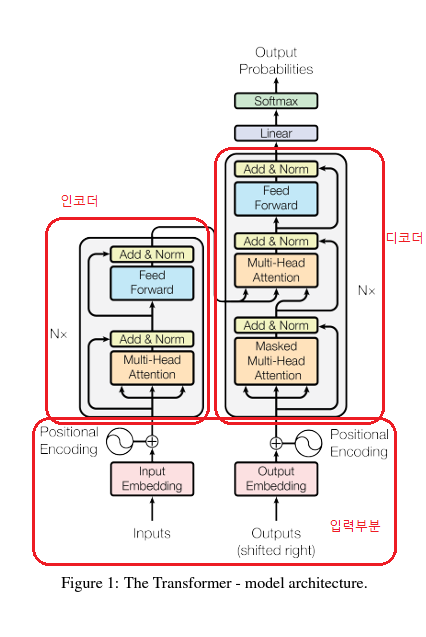
*   참고논문 : Atention Is All You Need(https://arxiv.org/pdf/1706.03762)





**트랜스포머와 인코더 디코더**

인코더와 디코더 구조

*   번역기는 인코더와 디코더 두 가지 아키텍처로 구성돼 있었습니다.
*   인코더에 입력 문장이 들어가고, 디코더는 이에 상응하는 출력 문장을 생성합니다.
*   이를 훈련한다는 것은 결국 입력 문장과 출력 문장 두 가지 병렬 구조로 구성된 데이터셋을 훈련한다는 의미였습니다.

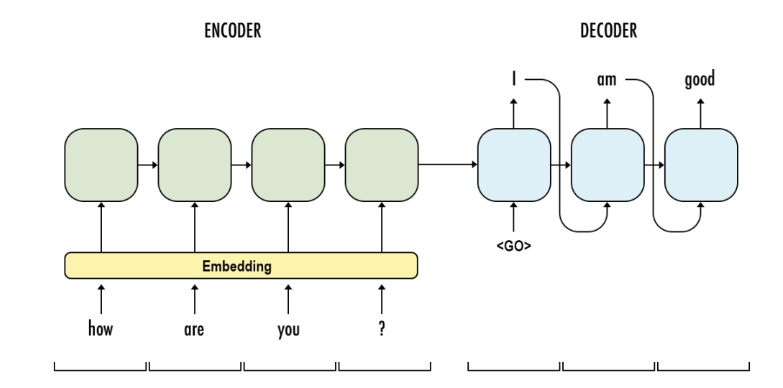



트랜스포머의 인코더와 디코더



*   트랜스포머 또한 번역기와 마찬가지로 기본적으로 인코더와 디코더 구성을 가지고 있습니다. 입력 문장을 넣으면 출력 문장을 내뱉고 있지요.
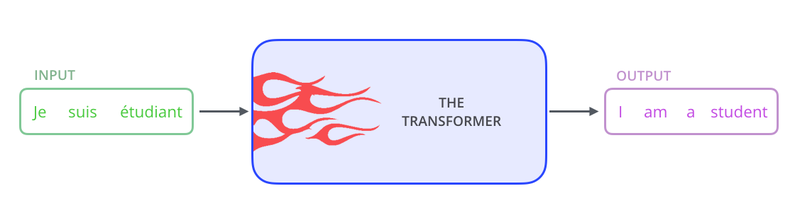





*   위의 블랙박스로 가려져 있는 트랜스포머의 내부 구조를 열어보면 아래와 같습니다!
*   초록색 색깔의 도형을 인코더 층(Encoder layer), 핑크색 색깔의 도형을 디코더(Decoder layer)라고 하였을 때, 입력 문장은 누적해 쌓아 올린 인코더의 층을 통해서 정보를 뽑아내고, 디코더는 누적해 쌓아 올린 디코더의 층을 통해서 출력 문장의 단어를 하나씩 만들어가는 구조를 갖고 있어요.


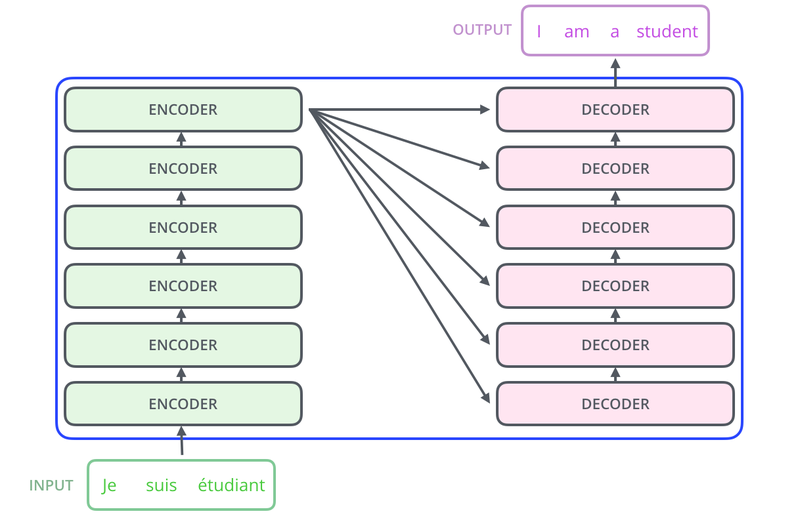





*   내부를 조금 더 확대해 보면 아래와 같이 톱니바퀴처럼 맞물려 돌아가는 여러 가지 부품들로 구성돼 있습니다.
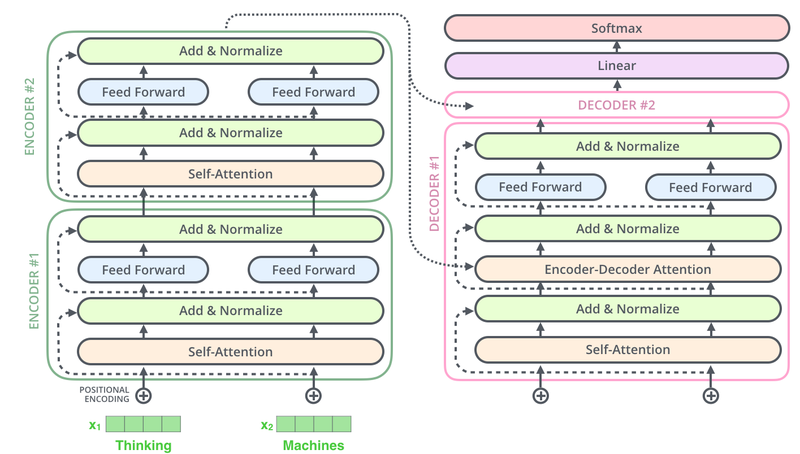


Q. 트랜스포머에서 인코더와 디코더는 어떤 역할을 수행하나요?

*   인코더는 입력 문장을 임베딩하고 문장의 의미를 파악하여 디코더에 전달합니다.
*   디코더는 인코더에서 전달 받은 정보를 기반으로 문장을 생성합니다.



출처 : https://jalammar.github.io/illustrated-transformer/

트랜스포머의 입력 이해하기

In [ ]:
!pip install sentencepiece

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt



*   많은 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거칩니다.  
*   트랜스포머 모델의 입력 데이터 처리에는 RNN 계열의 모델들과 다른 점이 한 가지 있습니다.
*   임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점입니다.
*   그 값은 바로 그림에서의 포지셔널 인코딩(positional Encoding)에 해당하는 부분입니다.

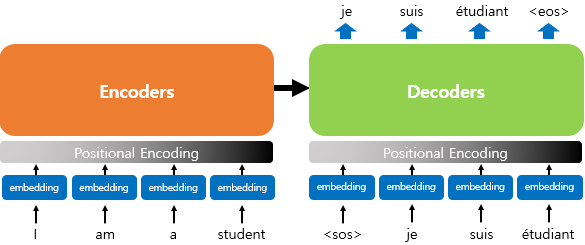







*   위 그림에서 인코더의 입력 부분을 조금 더 확대해 본다면 이런 그림이 나오겠죠?

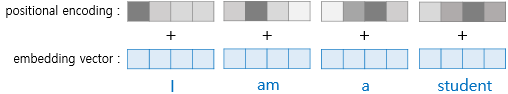



*   이렇게 해주는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문입니다.
*   트랜스포머가 RNN과 결정적으로 다른 점이 바로 이 부분입니다.
*   RNN에는 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없었습니다.
*   그러나 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 자칫 'I ate lunch'와 'lunch ate I'를 구분할 수 없을지도 모릅니다.
*   그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 삼는 것이지요!
*   포지셔널 인코딩의 벡터값은 위의 수식에 의해서 정해집니다.
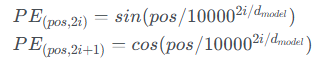





*   사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해 볼 수 있는데, 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더하여 줍니다.
*   위의 함수를 이해하기 위해서는 위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 합니다.
*   dmode은 임베딩 벡터의 차원을 의미하고 있고, pos는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, i는 임베딩 벡터 내의 차원의 인덱스를 의미합니다.
*   이렇게 임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해주게 되는 것이죠!
*   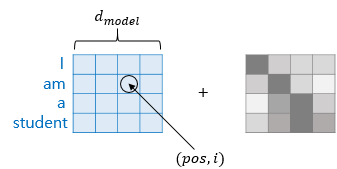

Q. 한 문장에 같은 단어 A가 여러 번 등장하였다고 가정해보겠습니다. 임베딩 문장 행렬에 포지셔널 인코딩을 해주었을 때와 해주지 않았을 때, 트랜스포머가 임베딩 문장 행렬 내의 다수의 A 단어 벡터로부터 얻을 수 있는 정보의 차이는 어떤 것이 있을까요?

*   같은 단어라고 하더라도 포지셔널 인코딩을 해준 경우에는 임베딩 벡터값이 달라지므로, 같은 단어라고 해도 각각 다른 위치에 등장했다는 사실을 모델에 알려줄 수 있습니다.



In [ ]:
# 포지셔널 행렬을 직접 구현

class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

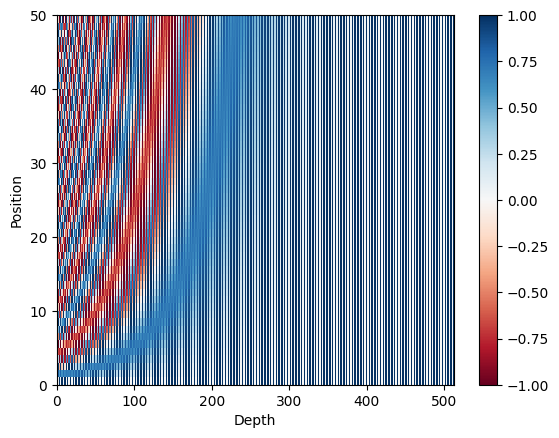

In [ ]:
# 행의 크기가 50, 열의 크기가 512인 행렬을 그려봅시다.
# 이를테면, 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것입니다.
# 행의 크기가 50, 열의 크기가 512인 행렬을 만드는 코드를 완성하여 입력 벡터 모양을 시각화하세요.

sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Q. 임베딩 벡터의 차원이 256이고 최대 문장의 길이가 30인 텍스트를 입력으로 하는 트랜스포머를 구현한다고 하였을 때, 적절한 포지셔널 인코딩 행렬의 크기를 추측해보고 위에 구현한 포지셔널 인코딩 레이어를 사용해 표현해 보세요.

*   위의 코드에서 50, 512 대신 30, 256을 입력으로 하여 행렬을 만들면 정답입니다. 즉 PositionalEncoding(30,256)로 표현할 수 있습니다.



**어텐션**

어텐션이란?



*   어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다.
*   구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영해 줍니다.
*   유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 합니다.

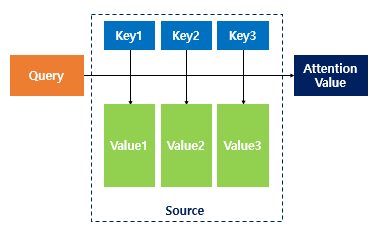


트랜스포머에서 사용된 어텐션


*   트랜스포머는 총 세 가지의 어텐션을 사용합니다.
*   첫 번째 그림인 인코더 셀프 어텐션은 인코더에서 이루어지고, 두 번째 그림인 디코더 셀프 어텐션은 디코더에서 이루어지며, 세 번째 그림인 인코더-디코더 어텐션 또한 디코더에서 이루어집니다.
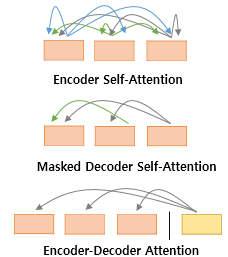





*   그림은 트랜스포머의 전체적인 아키텍처에서 각 어텐션이 위치한 곳을 보여줍니다.
*   트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value) 는 기본적으로 '단어 (정보를 함축한) 벡터' 입니다.
*   단, 여기서 '단어 벡터' 란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어 벡터 입니다.
*   세 가지 어텐션이 하는 일을 조금 더 자세히 알아보겠습니다.
    *   인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
    *   디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
    *   인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.
*   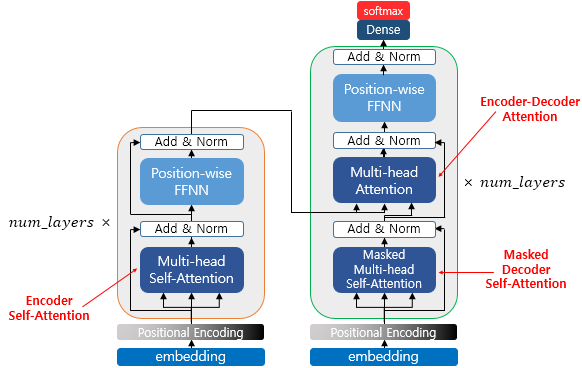




**셀프 어텐션(Self Attention)**



*   셀프 어텐션이란 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 말합니다.
*   가령, 위에서 언급한 인코더-디코더 어텐션은 서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구하기에 셀프 어텐션이 아닙니다.



*   예시 문장을 번역하면 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.' 라는 의미가 됩니다.
*   여기서 그것(it) 에 해당하는 것은 과연 길(street) 일까요? 동물(animal) 일까요?
*   우리는 동물이라는 것을 쉽게 알 수 있지만, 기계는 그렇지 않습니다.
*   하지만 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하여 그것(it) 이 동물(animal) 과 연관되었을 확률이 높다는 것을 찾아냅니다.
*   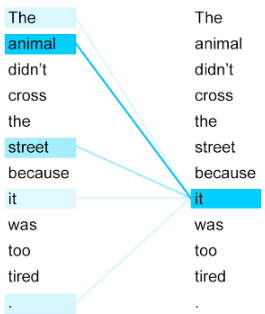




출처 :  구글 AI 블로그(https://research.google/blog/transformer-a-novel-neural-network-architecture-for-language-understanding/)

Q. 트랜스포머에서 사용되는 어텐션 중 셀프 어텐션을 사용하지 않는 것은 무엇인가요? 그리고 다른 어텐션과 차이점은 무엇인가요?
*   인코더-디코더 어텐션은 셀프 어텐션을 사용하지 않습니다.
*   셀프 어텐션은 같은 문장 내 단어들 간의 유사도를 계산하는 반면, 인코더-디코더 어텐션은 인코더의 입력 단어들과 디코더에서 생성 중인 단어들 간의 유사도를 계산합니다.
*   예를 들어 '저는 학생입니다.'라는 입력 문장의 '학생'과 'I am a student'라는 출력 문장 단어들 간의 유사도를 보는 방식입니다.

**스케일드 닷 프로덕트 어텐션**



*   트랜스포머에서는 어텐션 값을 구하는 방법으로 아래와 같은 수식을 사용했습니다.
*   Q, K, V 는 각각 쿼리(Query), 키(Key), 값(Value)를 나타냅니다.
*   어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해 줍니다.
*   유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 합니다.
*   위 정의와 아래 내용 세 가지만 기억하면 수식을 그림으로 정리할 수 있습니다.
    *   Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.
    *   벡터의 내적(dot product) 은 벡터의 유사도를 의미한다.
    *   특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.
*   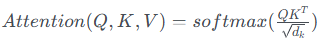










*   우선 Q와 K의 전치 행렬을 곱하는 것을 그림으로 표현하면 다음과 같습니다.
*   문장 행렬 Q와 문장 행렬 K를 곱하면 위의 그림과 같은 초록색 행렬을 얻을 수 있습니다.
*   위 초록색 행렬이 의미하는 값은 무엇일까요?
*   예를 들어 'am' 행과 'student' 열의 값은 Q 행렬에 있던 'am' 벡터와 K 행렬에 있던 'student 벡터'의 내적값을 의미합니다.
*   결국 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것이지요!
*   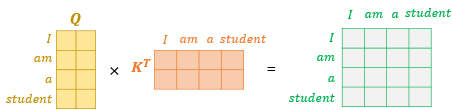










*   이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용합니다.
*   여기까지가 Q와 K의 유사도를 구하는 과정이라고 볼 수 있겠습니다.
*   여기에 문장 행렬와 곱하면 어텐션 값(Attention Value) 를 얻습니다.
*   이 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 하여 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention) 이라고 합니다.
*   유사도를 구하는 방법이 스케일드 닷 프로덕트(scaled dot product)였기 때문에 이런 이름이 붙은 것이지요.
*   만약에 분모에 특정 값을 나눠주는 부분을 사용하지 않았다면 어텐션의 이름은 무엇일까요? 그 어텐션은 당연히 닷 프로덕트 어텐션(dot product attention) 이라고 부릅니다.
*   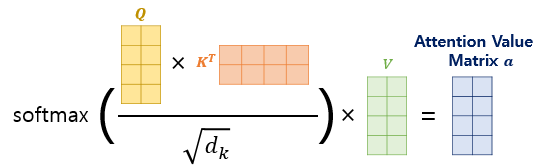
*   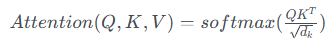




Q. 특정 값을 분모로 사용하여 스케일링(Scaling)을 하는 이유는 무엇인가요?

*   스케일링을 하지 않으면 벡터의 내적(dot product) 연산의 결과가 입력 벡터의 차원 수에 따라 크기가 매우 커지게 되고, softmax의 출력값이 작아지는 것을 방지하기 위해서 입니다.
*   softmax의 출력값이 작아지면 역전파 과정에서 기울기 소실 문제가 발생할 수 있습니다.



In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수

def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

**머리가 여러 개인 어텐션**

병렬로 어텐션 수행하기



*   트랜스포머에서 num_heads라는 변수는 기계가 몇 개의 똑똑한 머리를 사용할지, 다시 말해 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터입니다.
*   앞서 포지셔널 인코딩에서 d_model은 임베딩 벡터의 차원이라고 언급한 바 있습니다. 결국 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, d_model을 열의 크기로 가집니다.
*   트랜스포머는 이렇게 입력된 문장 행렬을 num_heads의 수만큼 쪼개서 어텐션을 수행하고, 이렇게 얻은 num_heads의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate합니다.
*   그림은 num_heads가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 d_model이 됩니다.
*   각자 문제지를 나눠서 푼 후에 마지막에 다시 결과를 합친다고 비유해볼 수도 있겠네요!
*   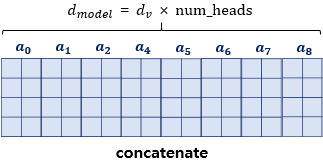



Q. 논문에서 d_model은 512의 값을 가졌다고 하고, num_heads는 8의 값을 가졌다고 해요. 그렇다면, 연결하기 전 8개의 어텐션 값(Attention Value) 행렬의 열의 크기는 몇 차원이었을까요?

*   512/8 = 64



멀티-헤드 어텐션



*   그림은 num_heads의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여줍니다.
*   다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있습니다.
*   예를 들어 위 그림에서라면 it_이라는 토큰이 animal_과 유사하다고 보는 관점과 street_과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하다는 뜻입니다.
*   이와 같이 어텐션을 병렬로 수행하는 것을 멀티 헤드 어텐션이라고 부릅니다.
*   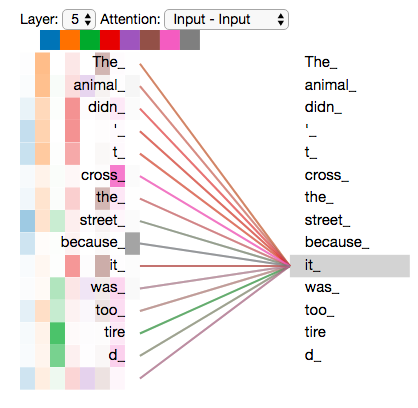





출처 : https://jalammar.github.io/illustrated-transformer/

In [ ]:
# 멀티 헤드 어텐션 구현
# 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output

**마스킹**



*   마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법입니다.



패딩 마스킹(Padding Masking)



*   첫 번째 마스킹은 패딩 토큰(Padding token)을 이용한 방법입니다.
*   패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법입니다.
*   그림은 케라스의 pad_sequences()를 사용하여 패딩을 하는 과정을 시각화한 그림입니다.
*   그런데 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있습니다.
*   패딩 마스킹은 이를 위해 숫자 0인 위치를 체크합니다.
*   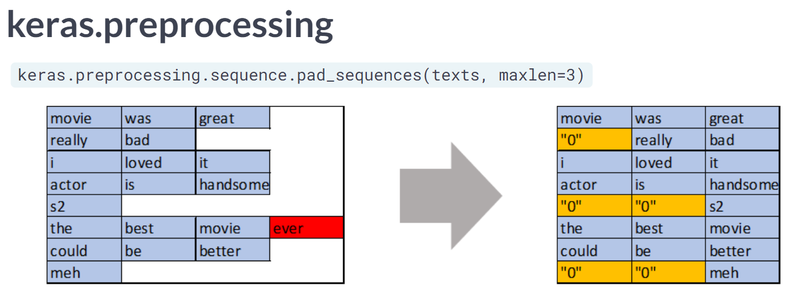




In [ ]:
# 패딩마스킹 구현 함수

def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

# 이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴합니다.

In [ ]:
# 두 개의 정수 시퀀스를 입력으로 해보고, 각각 어떤 결과가 나오는지 보겠습니다.

x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)

# 두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력합니다.
# 어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있겠죠?

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)



*   순환 신경망, RNN과 트랜스포머는 문장을 입력받을 때 입력받는 방법이 전혀 다릅니다.
*   RNN은 step이라는 개념이 존재해서 각 step마다 단어가 순서대로 입력으로 들어가는 구조인 반면 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있습니다. 그리고 이 특징 때문에 추가적인 마스킹(Masking) 을 필요합니다.
*   트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있습니다만, 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이니까요.
*   따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법입니다.
*   이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 합니다.
*   그림에서 빨간색으로 색칠된 부분은 마스킹을 표현하고 있습니다. 빨간색은 실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있습니다.
*   예를 들어 Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 S, 나는, 행복을, 찾고까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있습니다. 즉, 유사도를 구할 수 없도록 해놓았습니다.
*   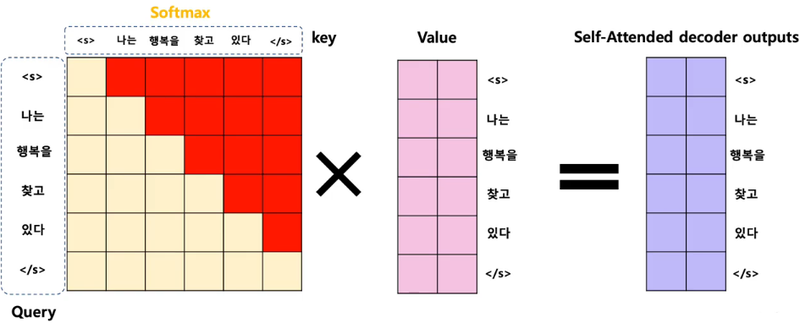
*   참고 : 서울대 산업공학과 DSBA 연구실(https://www.youtube.com/watch?v=xhY7m8QVKjo)






In [ ]:
# 빨간색 부분을 마스킹 함수로 구현하면 다음과 같습니다.

def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [ ]:
# 직접 입력을 넣어 테스트해 봅시다.

x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

# 대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있습니다.
# 그런데 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 합니다.
# 그래서 create_look_ahead_mask() 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있습니다.

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [ ]:
# 숫자 0이 포함되었을 경우에도 테스트해 봅시다.

x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


**인코더**

인코더 층 만들기



*   하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다.
*   바로 셀프 어텐션과 피드 포워드 신경망입니다.
*   셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다.

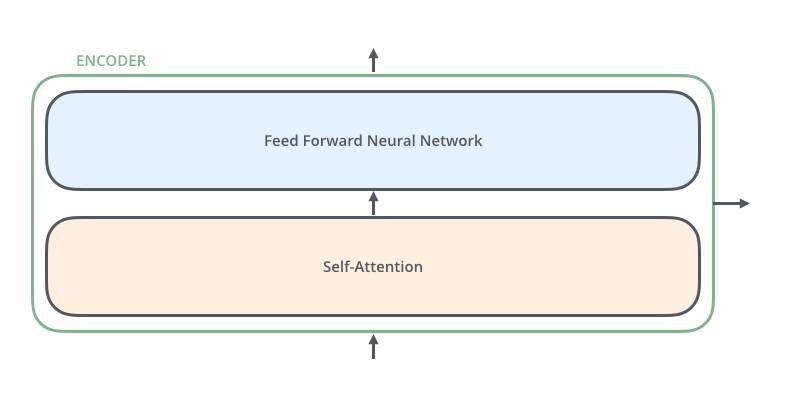


In [ ]:
# 두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같습니다.
# 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있습니다.

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


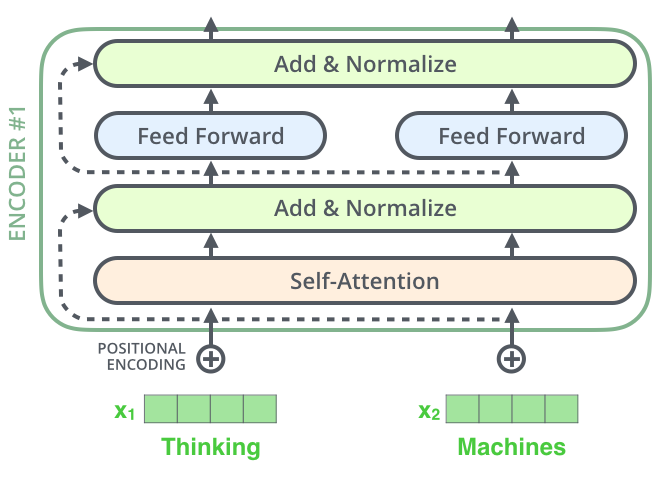

인코더 층을 쌓아 인코더 만들기



*   이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.
*   인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었습니다.
*   위 그림에서는 Normalize라고 표시된 부분에 해당됩니다.
*   트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다.



In [ ]:
# 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

**디코더**

디코더 층



*   첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다.
*   항인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다.
*   이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다.



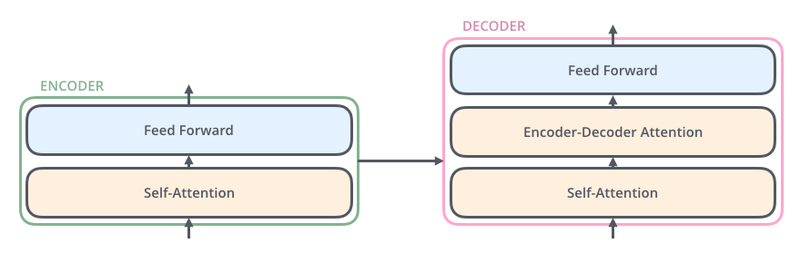

출처 : http://jalammar.github.io/illustrated-transformer/



*   인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행합니다.



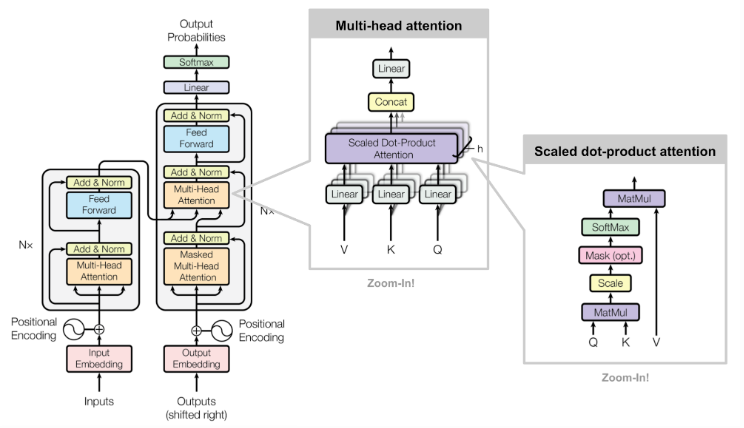

출처 : shreyasi kalra 미디움 블로그 "BERT Language Model"(https://medium.com/@shreyasikalra25/predict-movie-reviews-with-bert-88d8b79f5718)

In [ ]:
# 디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같습니다.

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

디코더 층을 쌓아 디코더 만들기



*   이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.
*   인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓습니다.



In [ ]:
# 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

# 이제 인코더 층과 디코더 층을 각각 함수로 구현하였습니다.
# 이를 하나로 조합하여 트랜스포머 모델을 만들 수 있을 텐데, 우선 그전에 여기서 사용할 챗봇 데이터를 로드하고, 전처리해보겠습니다.

**챗봇의 병렬 데이터 받아오기**



*   여기서는 Cornell Movie-Dialogs Corpus라는 영화 및 TV 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용합니다.
*   대화의 쌍이라고 하는 것은 기본적으로 먼저 말하는 사람의 대화 문장이 있고, 그에 응답하는 대화 문장의 쌍으로 이루어집니다.
*   데이터를 받아오는 이번 스텝에서 목표로 하는 것은 다음과 같습니다.
    *   정해진 개수인 50,000개의 질문과 답변의 쌍을 추출한다.
    *   문장에서 단어와 구두점 사이에 공백을 추가한다.
    *   알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.




In [ ]:
# 데이터 다운로드

# 코넬 대사 데이터셋 다운로드 URL
url = 'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip'
zip_filename = 'cornell_movie_dialogs.zip'

# 이미 파일이 없는 경우에만 다운로드
if not os.path.exists(zip_filename):
    print(f"Downloading {zip_filename} ...")
    urllib.request.urlretrieve(url, zip_filename)
    print("Download complete.")

# ZIP 파일 압축 해제
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content")  # 현재 디렉토리에 풀림

# 개별 파일 경로 설정
path_to_dataset = "/content/cornell movie-dialogs corpus"

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

print("path_to_dataset:", path_to_dataset)
print("path_to_movie_lines:", path_to_movie_lines)
print("path_to_movie_conversations:", path_to_movie_conversations)

path_to_dataset: /content/cornell movie-dialogs corpus
path_to_movie_lines: /content/cornell movie-dialogs corpus/movie_lines.txt
path_to_movie_conversations: /content/cornell movie-dialogs corpus/movie_conversations.txt


In [ ]:
# 여기서 우리가 사용할 데이터는 실습 시간을 고려하여 전체 데이터 중 일부입니다.
# 우선, 데이터 중에서 5만 개만 가져오도록 하고 질문과 답변의 쌍의 형태로 데이터셋을 가공합니다.

# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [ ]:
# 이를 위한 전처리 함수는 다음과 같습니다.
# 이번 전처리는 정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여 단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제하는 것을 목표로 합니다.

# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [ ]:
# 방금 만든 전처리 함수 테스트

sample_sentence = "안녕하세요? Hello! I'm a student😊, nice to meet you!"

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

? hello ! i m a student , nice to meet you !


In [ ]:
# 데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리합니다.

def read_cornell_data(path_to_movie_lines, path_to_movie_conversations, max_samples=50000):
    id2line = {}
    with open(path_to_movie_lines, 'r', errors='ignore') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) >= 5:
            line_id = parts[0]
            text = parts[4]
            id2line[line_id] = text

    pairs = []
    with open(path_to_movie_conversations, 'r', errors='ignore') as f:
        conv_lines = f.readlines()
    for line in conv_lines:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) < 4:
            continue
        # 대화 ID 목록 추출: ["L1045","L1044","L1043", ...]
        conv_str = parts[3]
        conv_list = conv_str[1:-1].split(", ")
        conv_list = [c.strip("'") for c in conv_list]  # "'L1045'" -> "L1045"

        # 연속된 두 문장씩 (질문, 답변) 구성
        for i in range(len(conv_list) - 1):
            q_id = conv_list[i]
            a_id = conv_list[i+1]
            q_text = id2line.get(q_id, "")
            a_text = id2line.get(a_id, "")
            # 간단 전처리(소문자 변환 정도만 예시)
            q_text = preprocess_sentence(q_text)
            a_text = preprocess_sentence(a_text)

            pairs.append((q_text, a_text))
            if len(pairs) >= max_samples:
                return pairs
    return pairs

In [ ]:
# 로드한 데이터의 샘플 수 확인

pairs = read_cornell_data(path_to_movie_lines, path_to_movie_conversations, max_samples=MAX_SAMPLES)

print('전체 샘플 수 :', len(pairs))

전체 샘플 수 : 50000


**병렬 데이터 전처리하기**



*   질문과 답변의 셋을 각각 pairs에 저장하였으므로, 본격적으로 전처리를 진행해보겠습니다.
*   이번 스텝에서 진행할 전체적인 과정을 요약하면 다음과 같습니다.
    *   Google SentencePiece 를 토크나이저로 사용한다. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩 한다.
    *   각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
    *   최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
    *   MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.





Tokenizer 학습하기

In [ ]:
# 단순한 규칙 기반, 혹은 미리 준비된 토크나이저의 경우 학습이 필요하지 않지만 데이터에 맞춰 단어사전을 작성하는 경우 학습이 필요합니다.
# 우선 위에서 만든 pair를 텍스트 파일에 저장시키겠습니다.

corpus_file = "clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [ ]:
# 질문-답변 쌍이 담긴 clean_corpus.txt 파일을 이용해 SentencePiece 모델을 훈련하고, 토크나이저가 담길 model / vocab 파일을 생성하겠습니다.

spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="spm_cornell",
    vocab_size=8000,
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)

In [ ]:
# 학습시킨 토크나이저를 불러와 테스트해보겠습니다.

sp = spm.SentencePieceProcessor()
sp.Load("spm_cornell.model")

True

In [ ]:
# 예제 문장
sentence = "I'm learning PyTorch with SentencePiece!"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)

전처리 후의 문장: i m learning pytorch with sentencepiece !
Tokenized: ['▁i', '▁m', '▁learning', '▁p', 'y', 't', 'or', 'ch', '▁with', '▁sent', 'ence', 'p', 'iece', '▁!']
Encoded: [6, 13, 4954, 37, 7983, 7971, 36, 119, 113, 1412, 651, 7991, 4122, 69]
Decoded: i m learning pytorch with sentencepiece !


Dataset 구현하기



*   Pytorch Dataset은 입력 파이프라인을 구축하는 API입니다.
*   이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 교사 강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해해야만 합니다. 아래의 글을 통해 교사 강요에 대해 알아봅시다. (모두 읽을 필요는 없고, 교사 강요 부분까지만 읽어도 됩니다.)
*   위키독스: RNN 언어 모델(https://wikidocs.net/46496)



Q. 교사 강요(Teacher Forcing)를 사용하지 않았을 경우, 훈련 과정에서 훈련 속도가 지나치게 느려지는 경우가 있다고 합니다. 그 이유는 무엇인가요?

*   교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.





*   이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 자기회귀 모델(auto-regressive model, AR) 이라고 합니다.
*   앞서 교사 강요를 이해하기 위해 읽었던 글에 등장한 RNN 언어 모델은 대표적인 자기 회귀 모델의 예이며, 트랜스포머의 디코더 또한 자기회귀 모델입니다.
*   트랜스포머 디코더에서도 교사 강요(Teacher Forcing) 를 적용합니다.



Q. 만약, answers의 한 샘플이 다음과 같았다고 해봅시다. 샘플 : '<START_TOKEN> I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> <PAD>' <START_TOKEN>은 문장의 시작을 의미하는 시작 토큰, <END_TOKEN>은 문장의 끝을 의미하는 종료 토큰 <PAD>는 패딩을 위해 사용되는 패딩 토큰입니다. 교사 강요를 적용하기 위해서 위 샘플을 디코더의 입력과 레이블로 사용한다고 하였을 때, 각각 어떻게 수정해서 입력과 레이블로 사용해야 할까요?

*   입력 : <START_TOKEN> I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD>
*   레이블 : I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> <PAD>



In [ ]:
# 질문과 답변의 쌍을 Dataset 의 입력으로 사용하여 파이프라인을 구성합니다.
# 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.
# 데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리합니다.

class CornellDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

In [ ]:
dataset = CornellDataset(pairs, sp, max_length=40)

In [ ]:
# 데이터셋에서 하나만 가져와보겠습니다.
# 다만 SentencePiece는 Decoding 과정에서 <s> 토큰이나 </s> 토큰은 생략하니 인덱스를 통해 잘 변환되는지 확인해보세요.
# (<s> 토큰의 인덱스는 1, </s> 토큰의 인덱스는 2 입니다)

for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([40])
tensor([   1,  115,   52,  321,   99, 1609,   23,  304, 7997, 7734,   62,   36,
        7978,  271,   61,   61,  891, 6222,  121, 1060,   39, 3631, 7741, 1337,
          15,  141,  280, 1882,  919,  161,   72,   19,  333,  103,    5,  463,
           5,    2,    0,    0])
can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .
tensor([   1,  189,   17,    6,  450,   52,   20,  539,  113,  523,   21,  182,
        5984,   17,  156,   57,   10,  358,  113,   14,    5,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
well , i thought we d start with pronunciation , if that s okay with you .
tensor([ 189,   17,    6,  450,   52,   20,  539,  113,  523,   21,  182, 5984,
          17,  156,   57,   10,  358,  113,   14,    5,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0

DataLoader 구성하기

In [ ]:
# 위와 같이 데이터를 Dataset 객체로 잘 만들었다면 데이터로더는 다음과 같이 간단하게 만들 수 있습니다.

dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [ ]:
# 데이터 로더의 경우 일반적인 인덱싱 방식으로 불러올 경우 에러가 나기 때문에 아래와 같이 for 문을 활용해 불러옵니다.
# 이미 데이터가 잘 들어있는지는 확인했기 때문에 여기에서는 batch 단위로 잘 불러와지는지만 확인하도록 하겠습니다.

for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


**모델 정의 및 학습하기**

In [ ]:
# 이제 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의합니다.

class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        src_key_padding_mask = create_padding_mask(inputs)

        enc_outputs = self.encoder(
            x=inputs,
            src_key_padding_mask=src_key_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

모델생성

In [ ]:
# num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값입니다.
# 논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용합니다.

# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_mha)

손실 함수(Loss function)

In [ ]:
# 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

커스텀 된 학습률(Learning rate)



*   딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다.
*   최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다.
*   이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.
*   논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다.
*   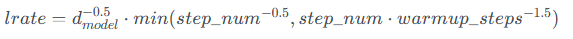



In [ ]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda



*   그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다.
*   위에 언급한 수식은 step_num^−0.5에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있습니다.
*   그래서 학습 초기에는 learning_rate가 step_num 에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있습니다.



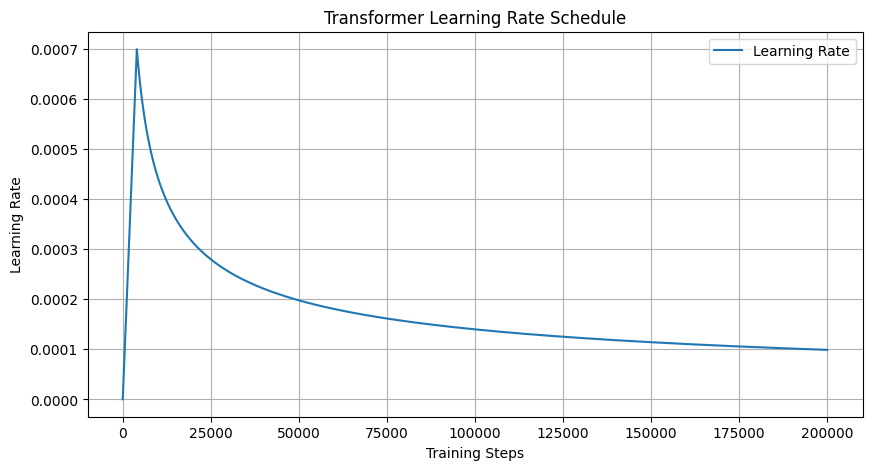

In [ ]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


모델 컴파일

In [ ]:
# 손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

훈련하기

In [ ]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [ ]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [ ]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,  # 원하는 에폭 수
    device=device
)

**챗봇 테스트하기**



*   예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

    *   새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
    *   입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
    *   패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
    *   디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
    *   디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
    *   END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.



In [ ]:
# 위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [ ]:
# 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [ ]:
# 임의의 문장으로부터 챗봇의 대답을 얻어봅시다.

sentence = 'Where have you been?'
sentence_generation(model, sentence, sp, device)

---
---
---

# **노드 18. 트랜스포머로 만드는 대화형 챗봇[프로젝트]**



**실험 개요**


1.   실험 목적

    *   트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행되는지 여부를 관찰한다.
    *   트랜스포머 모델은 한국어 기반으로 질문의 맥락을 이해하고 적합한 답변을 출력하는 수준까지 구현한다.
    *   트랜스포머 모델 구현 실험을 통하여 구조와 프로세스 등을 이해하고 추후 타 모델 학습의 응용 능력을 함양한다.


2.   실험 조건

    *   데이터셋 : 한국어 챗봇 데이터(https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
    *   실험차수 : 3차
    *   데이터 전처리 방식 : SentencePiece를 이용한 서브워드 토크나이징, 특수토큰 부여(<pad> = 0, <bos> = 1, <eos> = 2), 정규화 및 특수문자 제거
    *   평가 방식 : 응답 생성 성공률(정량평가), 일반적인 수준의 정상적인 문장 생성(정성평가)
    *   Transformer 기반 Encoder–Decoder 구조
        *  Embedding dimension : 256
        *  Encoder 및 Decoder layer : 각 4
        *  Attention head : 8
        *  Vocab size : 8,000
    *   학습조건
        *  Epochs : 1차 10, 2차 30, 3차 이후 50
        *  Batch size : 64


3.   가설 설정

    *   트랜스포머 모델의 학습시 에폭 수 10을 기본으로 증가할 수록 성능이 증가할 수 있다.
    *   모델의 학습률이 성능에 상당한 영향을 미칠 것이다.





---
---
# 1~3차 실험



Step 0. 환경설정

In [ ]:
# 필수 라이브러리

!pip install sentencepiece torch tqdm

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sentencepiece as spm
import re

Step 1. 데이터 수집하기

In [ ]:
# 데이터 다운로드

! mkdir -p content/work/transformer_chatbot/data/ && cd content/work/transformer_chatbot/data/
! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv

--2026-02-05 08:51:58--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2026-02-05 08:51:59--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv’

ChatbotData.csv     100%[===================>] 868.99K  --.-KB/s    in 0.03s   

2026-02-05 08:51:59 (27.4 MB/s) - ‘ChatbotData.csv’ saved [889842/889842]



In [ ]:
# 데이터 로드

data_path = "/content/ChatbotData.csv"
df = pd.read_csv(data_path)

df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
# 데이터 확인

print(len(df))

11823


**Step 2. 데이터 전처리하기**

In [ ]:
# 한국어 문장 정규화 및 특수문자 제거

def clean_text(text):
    text = text.strip()
    text = re.sub(r"[^가-힣0-9a-zA-Z\s\.\?\!]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text

df["Q"] = df["Q"].apply(clean_text)
df["A"] = df["A"].apply(clean_text)

**Step 3. SentencePiece 사용하기**

In [ ]:
# 학습용 텍스트 생성

corpus_path = "/content/corpus.txt"

with open(corpus_path, "w", encoding="utf-8") as f:
    for q, a in zip(df["Q"], df["A"]):
        f.write(q + "\n")
        f.write(a + "\n")

In [ ]:
# SentencePiece BPE 학습(토크나이징 적용)

spm.SentencePieceTrainer.train(
    input=corpus_path,
    model_prefix="chatbot_sp",
    vocab_size=8000,
    model_type="bpe",
    bos_id=1,
    eos_id=2,
    pad_id=0,
    unk_id=3
)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load("chatbot_sp.model")

True

In [ ]:
# 병렬 데이터셋 구축

class ChatbotDataset(Dataset):
    def __init__(self, df, sp, max_len=40):
        self.sp = sp
        self.max_len = max_len
        self.data = []

        for q, a in zip(df["Q"], df["A"]):
            enc = sp.encode(q, out_type=int)[:max_len-2]
            dec = sp.encode(a, out_type=int)[:max_len-2]

            enc = [1] + enc + [2]   # <bos>, <eos>
            dec = [1] + dec + [2]

            self.data.append((enc, dec))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def collate_fn(batch):
    encs, decs = zip(*batch)

    enc_len = max(len(e) for e in encs)
    dec_len = max(len(d) for d in decs)

    enc_pad = [e + [0]*(enc_len-len(e)) for e in encs]
    dec_pad = [d + [0]*(dec_len-len(d)) for d in decs]

    return torch.tensor(enc_pad), torch.tensor(dec_pad)

In [ ]:
dataset = ChatbotDataset(df, sp)
loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

**Step 4. 모델 구성하기**

In [ ]:
# Transformer 모델 구현

class TransformerChatbot(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        src_emb = self.embedding(src)
        tgt_emb = self.embedding(tgt)

        tgt_mask = generate_square_subsequent_mask(
            tgt.size(1),
            tgt.device
        )

        out = self.transformer(
            src_emb,
            tgt_emb,
            tgt_mask=tgt_mask
        )
        return self.fc(out)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TransformerChatbot(vocab_size=8000).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Causal Mask 추가(3차 실험 추가)

def generate_square_subsequent_mask(sz, device):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), device=device),
        diagonal=1
    )

In [ ]:
# Padding Mask 추가(3차 실험 추가)
  # PAD 토큰(0)을 attention에서 완전히 무시
  # 없을 경우 디코더가 PAD → eos 패턴을 학습하고 epoch 100이어도 무응답 발생 가능

def forward(self, src, tgt):
    src_emb = self.embedding(src)
    tgt_emb = self.embedding(tgt)

    tgt_mask = generate_square_subsequent_mask(
        tgt.size(1),
        tgt.device
    )

    src_key_padding_mask = (src == 0)
    tgt_key_padding_mask = (tgt == 0)

    out = self.transformer(
        src_emb,
        tgt_emb,
        tgt_mask=tgt_mask,
        src_key_padding_mask=src_key_padding_mask,
        tgt_key_padding_mask=tgt_key_padding_mask
    )
    return self.fc(out)

In [ ]:
# 모델 학습

EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for enc, dec in tqdm(loader):
        enc, dec = enc.to(device), dec.to(device)

        optimizer.zero_grad()
        output = model(enc, dec[:, :-1])

        loss = criterion(
            output.reshape(-1, output.size(-1)),
            dec[:, 1:].reshape(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(loader):.4f}")

100%|██████████| 185/185 [00:08<00:00, 22.24it/s]


[Epoch 1] Loss: 6.2939


100%|██████████| 185/185 [00:10<00:00, 17.81it/s]


[Epoch 2] Loss: 5.5798


100%|██████████| 185/185 [00:08<00:00, 22.77it/s]


[Epoch 3] Loss: 5.2621


100%|██████████| 185/185 [00:08<00:00, 21.84it/s]


[Epoch 4] Loss: 5.0035


100%|██████████| 185/185 [00:07<00:00, 23.54it/s]


[Epoch 5] Loss: 4.7743


100%|██████████| 185/185 [00:07<00:00, 23.38it/s]


[Epoch 6] Loss: 4.5614


100%|██████████| 185/185 [00:07<00:00, 23.50it/s]


[Epoch 7] Loss: 4.3595


100%|██████████| 185/185 [00:07<00:00, 23.53it/s]


[Epoch 8] Loss: 4.1587


100%|██████████| 185/185 [00:07<00:00, 23.25it/s]


[Epoch 9] Loss: 3.9678


100%|██████████| 185/185 [00:07<00:00, 23.34it/s]


[Epoch 10] Loss: 3.7782


100%|██████████| 185/185 [00:08<00:00, 23.11it/s]


[Epoch 11] Loss: 3.5906


100%|██████████| 185/185 [00:08<00:00, 22.91it/s]


[Epoch 12] Loss: 3.4090


100%|██████████| 185/185 [00:07<00:00, 23.21it/s]


[Epoch 13] Loss: 3.2261


100%|██████████| 185/185 [00:07<00:00, 23.15it/s]


[Epoch 14] Loss: 3.0497


100%|██████████| 185/185 [00:08<00:00, 23.09it/s]


[Epoch 15] Loss: 2.8717


100%|██████████| 185/185 [00:07<00:00, 23.27it/s]


[Epoch 16] Loss: 2.6923


100%|██████████| 185/185 [00:07<00:00, 23.33it/s]


[Epoch 17] Loss: 2.5125


100%|██████████| 185/185 [00:07<00:00, 23.20it/s]


[Epoch 18] Loss: 2.3379


100%|██████████| 185/185 [00:07<00:00, 23.26it/s]


[Epoch 19] Loss: 2.1718


100%|██████████| 185/185 [00:07<00:00, 23.28it/s]


[Epoch 20] Loss: 2.0021


100%|██████████| 185/185 [00:08<00:00, 23.09it/s]


[Epoch 21] Loss: 1.8423


100%|██████████| 185/185 [00:07<00:00, 23.31it/s]


[Epoch 22] Loss: 1.6951


100%|██████████| 185/185 [00:08<00:00, 23.09it/s]


[Epoch 23] Loss: 1.5550


100%|██████████| 185/185 [00:08<00:00, 22.96it/s]


[Epoch 24] Loss: 1.4153


100%|██████████| 185/185 [00:07<00:00, 23.22it/s]


[Epoch 25] Loss: 1.2886


100%|██████████| 185/185 [00:07<00:00, 23.22it/s]


[Epoch 26] Loss: 1.1671


100%|██████████| 185/185 [00:08<00:00, 23.11it/s]


[Epoch 27] Loss: 1.0544


100%|██████████| 185/185 [00:07<00:00, 23.31it/s]


[Epoch 28] Loss: 0.9503


100%|██████████| 185/185 [00:07<00:00, 23.21it/s]


[Epoch 29] Loss: 0.8480


100%|██████████| 185/185 [00:08<00:00, 23.02it/s]


[Epoch 30] Loss: 0.7563


100%|██████████| 185/185 [00:07<00:00, 23.32it/s]


[Epoch 31] Loss: 0.6726


100%|██████████| 185/185 [00:07<00:00, 23.35it/s]


[Epoch 32] Loss: 0.5902


100%|██████████| 185/185 [00:07<00:00, 23.28it/s]


[Epoch 33] Loss: 0.5271


100%|██████████| 185/185 [00:07<00:00, 23.29it/s]


[Epoch 34] Loss: 0.4588


100%|██████████| 185/185 [00:07<00:00, 23.24it/s]


[Epoch 35] Loss: 0.4001


100%|██████████| 185/185 [00:07<00:00, 23.21it/s]


[Epoch 36] Loss: 0.3493


100%|██████████| 185/185 [00:07<00:00, 23.28it/s]


[Epoch 37] Loss: 0.3069


100%|██████████| 185/185 [00:07<00:00, 23.27it/s]


[Epoch 38] Loss: 0.2637


100%|██████████| 185/185 [00:08<00:00, 23.07it/s]


[Epoch 39] Loss: 0.2317


100%|██████████| 185/185 [00:07<00:00, 23.41it/s]


[Epoch 40] Loss: 0.2032


100%|██████████| 185/185 [00:07<00:00, 23.34it/s]


[Epoch 41] Loss: 0.1804


100%|██████████| 185/185 [00:07<00:00, 23.23it/s]


[Epoch 42] Loss: 0.1541


100%|██████████| 185/185 [00:07<00:00, 23.30it/s]


[Epoch 43] Loss: 0.1395


100%|██████████| 185/185 [00:07<00:00, 23.27it/s]


[Epoch 44] Loss: 0.1238


100%|██████████| 185/185 [00:07<00:00, 23.18it/s]


[Epoch 45] Loss: 0.1109


100%|██████████| 185/185 [00:07<00:00, 23.36it/s]


[Epoch 46] Loss: 0.1009


100%|██████████| 185/185 [00:07<00:00, 23.19it/s]


[Epoch 47] Loss: 0.0926


100%|██████████| 185/185 [00:07<00:00, 23.15it/s]


[Epoch 48] Loss: 0.0837


100%|██████████| 185/185 [00:07<00:00, 23.39it/s]


[Epoch 49] Loss: 0.0776


100%|██████████| 185/185 [00:08<00:00, 23.11it/s]

[Epoch 50] Loss: 0.0725


**Step 5. 모델 평가하기**

In [ ]:
# 예측 함수
def predict(sentence, model, sp, max_len=40, min_len=3):
    model.eval()

    src = sp.encode(clean_text(sentence), out_type=int)
    src = torch.tensor([[1] + src + [2]]).to(device)

    tgt = torch.tensor([[1]]).to(device)

    for step in range(max_len):
        with torch.no_grad():
            out = model(src, tgt)
            probs = torch.softmax(out[:, -1], dim=-1)
            next_token = torch.multinomial(probs, 1).item()

        # 최소 길이 전에는 eos 금지
        if next_token == 2 and step < min_len:
            continue

        if next_token == 2:
            break

        tgt = torch.cat(
            [tgt, torch.tensor([[next_token]], device=device)],
            dim=1
        )

    return sp.decode(tgt[0].tolist()[1:])

In [ ]:
test_sentences = [
    "안녕하세요",
    "오늘 너무 피곤해",
    "요즘 고민이 많아",
    "고마워",
    "요즘 우울해"
]

for s in test_sentences:
    print("Q:", s)
    print("A:", predict(s, model, sp))
    print("-"*30)

Q: 안녕하세요
A: 기원합니다.
------------------------------
Q: 오늘 너무 피곤해
A: 푹 쉬세요.
------------------------------
Q: 요즘 고민이 많아
A: 어려운 일이에요.
------------------------------
Q: 고마워
A: 감사합니다.
------------------------------
Q: 요즘 우울해
A: 감정을 나누는게 어려운 일이에요.
------------------------------


In [ ]:
test_sentences = [
    "안녕",
    "오늘 너무 피곤해",
    "요즘 고민이 많아",
    "사람 관계가 어려워",
    "고마워",
    "미안해",
    "요즘 우울해"
]

success = 0
for s in test_sentences:
    output = predict(s, model, sp)
    if output.strip() != "":
        success += 1

print("응답 생성 성공률:", success / len(test_sentences))

응답 생성 성공률: 1.0


---
---
# 4차 실험


Step 0. 환경설정

In [ ]:
# 필수 라이브러리

!pip install sentencepiece torch tqdm

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sentencepiece as spm
import re

Step 1. 데이터 수집하기

In [ ]:
# 데이터 다운로드

! mkdir -p content/work/transformer_chatbot/data/ && cd content/work/transformer_chatbot/data/
! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv

--2026-02-06 07:27:20--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2026-02-06 07:27:20--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv.1’

ChatbotData.csv.1   100%[===================>] 868.99K  --.-KB/s    in 0.02s   

2026-02-06 07:27:21 (35.0 MB/s) - ‘ChatbotData.csv.1’ saved [889842/889842]



In [ ]:
# 데이터 로드

data_path = "/content/ChatbotData.csv"
df = pd.read_csv(data_path)

df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
# 데이터 확인

print(len(df))

11823


**Step 2. 데이터 전처리하기**

In [ ]:
# 한국어 문장 정규화 및 특수문자 제거

def clean_text(text):
    text = text.strip()
    text = re.sub(r"[^가-힣0-9a-zA-Z\s\.\?\!]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text

df["Q"] = df["Q"].apply(clean_text)
df["A"] = df["A"].apply(clean_text)

**Step 3. SentencePiece 사용하기**

In [ ]:
# 학습용 텍스트 생성

corpus_path = "/content/corpus.txt"

with open(corpus_path, "w", encoding="utf-8") as f:
    for q, a in zip(df["Q"], df["A"]):
        f.write(q + "\n")
        f.write(a + "\n")

In [ ]:
# SentencePiece BPE 학습(토크나이징 적용)

spm.SentencePieceTrainer.train(
    input=corpus_path,
    model_prefix="chatbot_sp",
    vocab_size=8000,
    model_type="bpe",
    bos_id=1,
    eos_id=2,
    pad_id=0,
    unk_id=3
)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load("chatbot_sp.model")

True

In [ ]:
PAD_ID = sp.pad_id() if sp.pad_id() != -1 else 0
BOS_ID = sp.bos_id()
EOS_ID = sp.eos_id()
VOCAB_SIZE = sp.get_piece_size()

print("PAD, BOS, EOS, VOCAB:", PAD_ID, BOS_ID, EOS_ID, VOCAB_SIZE)


PAD, BOS, EOS, VOCAB: 0 1 2 8000


In [ ]:
# 병렬 데이터셋 구축

class ChatbotDataset(Dataset):
    def __init__(self, df, sp, max_len=40):
        self.sp = sp
        self.max_len = max_len
        self.data = []

        for q, a in zip(df["Q"], df["A"]):
            enc = sp.encode(q, out_type=int)[:max_len-2]
            dec = sp.encode(a, out_type=int)[:max_len-2]

            enc = [1] + enc + [2]   # <bos>, <eos>
            dec = [1] + dec + [2]

            self.data.append((enc, dec))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def collate_fn(batch):
    encs, decs = zip(*batch)

    enc_len = max(len(e) for e in encs)
    dec_len = max(len(d) for d in decs)

    enc_pad = [e + [0]*(enc_len-len(e)) for e in encs]
    dec_pad = [d + [0]*(dec_len-len(d)) for d in decs]

    return torch.tensor(enc_pad), torch.tensor(dec_pad)

In [ ]:
dataset = ChatbotDataset(df, sp)
loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

**Step 4. 모델 구성하기**

In [ ]:
# Transformer 모델 구현

class TransformerChatbot(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size, d_model, padding_idx=PAD_ID
        )

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        src_key_padding_mask = (src == PAD_ID)
        tgt_key_padding_mask = (tgt == PAD_ID)

        tgt_mask = generate_square_subsequent_mask(
            tgt.size(1), tgt.device
        )

        src = self.embedding(src)
        tgt = self.embedding(tgt)

        out = self.transformer(
            src,
            tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )

        return self.fc(out)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

model = TransformerChatbot(vocab_size=8000).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device: cuda


In [ ]:
# Causal Mask 추가(3차 실험 추가)

def generate_square_subsequent_mask(sz, device):
    mask = torch.triu(
        torch.ones(sz, sz, device=device),
        diagonal=1
    )
    return mask.masked_fill(mask == 1, float("-inf"))

In [ ]:
# Padding Mask 추가
  # PAD 토큰(0)을 attention에서 완전히 무시
  # 없을 경우 디코더가 PAD → eos 패턴을 학습하고 epoch 100이어도 무응답 발생 가능

def forward(self, src, tgt):
    src_emb = self.embedding(src)
    tgt_emb = self.embedding(tgt)

    tgt_mask = generate_square_subsequent_mask(
        tgt.size(1),
        tgt.device
    )

    src_key_padding_mask = (src == 0)
    tgt_key_padding_mask = (tgt == 0)

    out = self.transformer(
        src_emb,
        tgt_emb,
        tgt_mask=tgt_mask,
        src_key_padding_mask=src_key_padding_mask,
        tgt_key_padding_mask=tgt_key_padding_mask
    )
    return self.fc(out)

In [ ]:
# 모델 학습

EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for enc, dec in tqdm(loader):
        enc, dec = enc.to(device), dec.to(device)

        optimizer.zero_grad()
        output = model(enc, dec[:, :-1])

        loss = criterion(
            output.reshape(-1, output.size(-1)),
            dec[:, 1:].reshape(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(loader):.4f}")

  0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 185/185 [00:07<00:00, 24.59it/s]


[Epoch 1] Loss: 6.3126


100%|██████████| 185/185 [00:06<00:00, 30.07it/s]


[Epoch 2] Loss: 5.5905


100%|██████████| 185/185 [00:06<00:00, 29.13it/s]


[Epoch 3] Loss: 5.2736


100%|██████████| 185/185 [00:06<00:00, 29.68it/s]


[Epoch 4] Loss: 5.0126


100%|██████████| 185/185 [00:06<00:00, 27.10it/s]


[Epoch 5] Loss: 4.7836


100%|██████████| 185/185 [00:06<00:00, 29.19it/s]


[Epoch 6] Loss: 4.5703


100%|██████████| 185/185 [00:06<00:00, 28.36it/s]


[Epoch 7] Loss: 4.3707


100%|██████████| 185/185 [00:06<00:00, 26.50it/s]


[Epoch 8] Loss: 4.1742


100%|██████████| 185/185 [00:06<00:00, 27.93it/s]


[Epoch 9] Loss: 3.9749


100%|██████████| 185/185 [00:06<00:00, 28.32it/s]


[Epoch 10] Loss: 3.7834


100%|██████████| 185/185 [00:06<00:00, 28.00it/s]


[Epoch 11] Loss: 3.5865


100%|██████████| 185/185 [00:06<00:00, 28.61it/s]


[Epoch 12] Loss: 3.3884


100%|██████████| 185/185 [00:06<00:00, 28.67it/s]


[Epoch 13] Loss: 3.1908


100%|██████████| 185/185 [00:06<00:00, 28.28it/s]


[Epoch 14] Loss: 2.9891


100%|██████████| 185/185 [00:06<00:00, 29.27it/s]


[Epoch 15] Loss: 2.7983


100%|██████████| 185/185 [00:06<00:00, 28.81it/s]


[Epoch 16] Loss: 2.6083


100%|██████████| 185/185 [00:06<00:00, 29.14it/s]


[Epoch 17] Loss: 2.4258


100%|██████████| 185/185 [00:06<00:00, 28.42it/s]


[Epoch 18] Loss: 2.2510


100%|██████████| 185/185 [00:06<00:00, 29.12it/s]


[Epoch 19] Loss: 2.0803


100%|██████████| 185/185 [00:06<00:00, 28.46it/s]


[Epoch 20] Loss: 1.9209


100%|██████████| 185/185 [00:06<00:00, 29.08it/s]


[Epoch 21] Loss: 1.7650


100%|██████████| 185/185 [00:06<00:00, 28.29it/s]


[Epoch 22] Loss: 1.6212


100%|██████████| 185/185 [00:06<00:00, 28.89it/s]


[Epoch 23] Loss: 1.4821


100%|██████████| 185/185 [00:06<00:00, 28.38it/s]


[Epoch 24] Loss: 1.3532


100%|██████████| 185/185 [00:06<00:00, 28.58it/s]


[Epoch 25] Loss: 1.2297


100%|██████████| 185/185 [00:06<00:00, 28.67it/s]


[Epoch 26] Loss: 1.1139


100%|██████████| 185/185 [00:06<00:00, 28.36it/s]


[Epoch 27] Loss: 1.0074


100%|██████████| 185/185 [00:06<00:00, 29.02it/s]


[Epoch 28] Loss: 0.9055


100%|██████████| 185/185 [00:06<00:00, 28.43it/s]


[Epoch 29] Loss: 0.8152


100%|██████████| 185/185 [00:06<00:00, 29.22it/s]


[Epoch 30] Loss: 0.7264


100%|██████████| 185/185 [00:06<00:00, 28.42it/s]


[Epoch 31] Loss: 0.6507


100%|██████████| 185/185 [00:06<00:00, 28.98it/s]


[Epoch 32] Loss: 0.5774


100%|██████████| 185/185 [00:06<00:00, 28.31it/s]


[Epoch 33] Loss: 0.5093


100%|██████████| 185/185 [00:06<00:00, 29.01it/s]


[Epoch 34] Loss: 0.4525


100%|██████████| 185/185 [00:06<00:00, 28.35it/s]


[Epoch 35] Loss: 0.3958


100%|██████████| 185/185 [00:06<00:00, 29.01it/s]


[Epoch 36] Loss: 0.3523


100%|██████████| 185/185 [00:06<00:00, 28.33it/s]


[Epoch 37] Loss: 0.3099


100%|██████████| 185/185 [00:06<00:00, 28.78it/s]


[Epoch 38] Loss: 0.2705


100%|██████████| 185/185 [00:06<00:00, 28.47it/s]


[Epoch 39] Loss: 0.2415


100%|██████████| 185/185 [00:06<00:00, 28.55it/s]


[Epoch 40] Loss: 0.2140


100%|██████████| 185/185 [00:06<00:00, 28.88it/s]


[Epoch 41] Loss: 0.1888


100%|██████████| 185/185 [00:06<00:00, 28.37it/s]


[Epoch 42] Loss: 0.1682


100%|██████████| 185/185 [00:06<00:00, 28.84it/s]


[Epoch 43] Loss: 0.1524


100%|██████████| 185/185 [00:06<00:00, 28.35it/s]


[Epoch 44] Loss: 0.1359


100%|██████████| 185/185 [00:06<00:00, 28.87it/s]


[Epoch 45] Loss: 0.1239


100%|██████████| 185/185 [00:06<00:00, 28.31it/s]


[Epoch 46] Loss: 0.1155


100%|██████████| 185/185 [00:06<00:00, 28.92it/s]


[Epoch 47] Loss: 0.1029


100%|██████████| 185/185 [00:06<00:00, 28.35it/s]


[Epoch 48] Loss: 0.0942


100%|██████████| 185/185 [00:06<00:00, 28.94it/s]


[Epoch 49] Loss: 0.0873


100%|██████████| 185/185 [00:06<00:00, 28.16it/s]

[Epoch 50] Loss: 0.0808


**Step 5. 모델 평가하기**

In [ ]:
# 예측 함수

def predict(sentence, model, sp, max_len=40, repetition_penalty=1.2):
    model.eval()

    # Encoder
    src_ids = sp.encode(sentence, out_type=int)
    src_ids = [t for t in src_ids if 0 <= t < VOCAB_SIZE]

    src = torch.tensor(
        [[BOS_ID] + src_ids + [EOS_ID]],
        dtype=torch.long,
        device=device
    )

    # Decoder
    tgt = torch.tensor([[BOS_ID]], dtype=torch.long, device=device)
    generated = []

    for _ in range(max_len):
        with torch.no_grad():
            out = model(src, tgt)
            logits = out[:, -1]

            # repetition penalty
            for token in set(generated):
                logits[0, token] /= repetition_penalty

            next_token = logits.argmax(dim=-1).item()

        if next_token == EOS_ID:
            break

        if not (0 <= next_token < VOCAB_SIZE):
            break

        generated.append(next_token)

        tgt = torch.cat(
            [tgt, torch.tensor([[next_token]], device=device)],
            dim=1
        )

    return sp.decode(generated)


In [ ]:
test_sentences = [
    "바보야",
    "당신을 사랑합니다",
    "오늘 날씨 어때?",
    "여자친구를 사귀는 방법을 알려줘",
    "나랑 축구하자"
]

for s in test_sentences:
    print("Q:", s)
    print("A:", predict(s, model, sp))
    print("-"*30)

Q: 바보야
A: 마음 단단히 잡으세요.
------------------------------
Q: 당신을 사랑합니다
A: 저도 그렇게 생각해요.
------------------------------
Q: 오늘 날씨 어때?
A: 날씨 어플에 물어보세요.
------------------------------
Q: 여자친구를 사귀는 방법을 알려줘
A: 잠시 차분하게 생각해봐요.
------------------------------
Q: 나랑 축구하자
A: 축구 볼때는 치맥이죠.
------------------------------


In [ ]:
test_sentences = [
    "안녕",
    "오늘 너무 피곤해",
    "요즘 고민이 많아",
    "사람 관계가 어려워",
    "고마워",
    "미안해",
    "요즘 우울해"
]

success = 0
for s in test_sentences:
    output = predict(s, model, sp)
    if output.strip() != "":
        success += 1

print("응답 생성 성공률:", success / len(test_sentences))

응답 생성 성공률: 1.0


**실험 결과 보고서**

1.   실험 결과(Chat GPT를 통하여 성능 향상 방법을 일부 참조하였음)

    *   1차 실험

      *  에폭 수 10으로 설정 시 대부분의 응답이 무응답 출력
      *  모델의 응답 생성 성공률이 0%로 출력

    *   2차 실험

      *  에폭 수 30으로 설정 시 일부 간단한 질의(안녕 등)에 대한 응답은 출력하였으나 "오늘 너무 피곤해"와 같은 조금 더 긴 표현에는 응답을 하지 못하엿음
      *  모델의 응답 생성 성공률이 약 14%(0.14285)의 성능 구현

    *   3차 실험

      *  **에폭 수 50 설정, decoder causal mask(시간의 순서를 정하여 의미없는 토큰 출력 방지), padding mask(조기 종료에 따른 무응답 방지)**적용
      *  모델의 응답 생성 성공률이 100%(1.0)의 성능 구현
      *  맥락과 무관한 응답이 여전히 출력되고 있음

    *   4차 실험

      *  에폭 수 50 설정, decoder causal mask(시간의 순서를 정하여 의미없는 토큰 출력 방지), padding mask(조기 종료에 따른 무응답 방지), **예측함수 수정(greedy decoding(1등 확률 단어 선별)과 repetition penalty(동일 단어 반복 제한), vocab 범위 강제 제한(사전에 없는 단어 출력 불가))** 적용
      *  모델의 응답 생성 성공률이 100%(1.0)의 성능 구현
      *  3차 실험보다 맥락에 자연스러운 답변이 출력

    *   종합 결과

      *  에폭 수의 증가에 따라 Loss의 감소 추세를 보인 바와 같이 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습시 안정적으로 수렴하는 것에 이상이 없음을 확인


2.   결과 의미

    *   에폭 수 증가를 통하여 모델을 학습하였음에도 불구하고 무응답 현상이 빈번하게 발생하였는데 이는 attention mask 설계가 생략된 상태로 추론 단계(질문을 이해하고 답변을 예측하는 프로세스)에서 조기 종료가 발생하였다고 판단됨
    *   트랜스포머의 성능은 에폭 수의 영향은 미비하였으며, attention mask 설계(Casual mask와 Padding mask 적용), 토크나이징, 디코더와 인코더의 관계 설정 등의 영향이 크게 좌우 하는 것으로 실험을 통하여 유의미한 결과를 도출하였음


3.   실험의 한계점 및 보완점

    *   코더의 직관에 의존하여 답변의 품질을 평가하였으나 리뷰어의 관점이 다를 수 있으므로 출력의 질을 평가하는 정량적 지표가 필요
    *   에폭 수 증가와 Loss 감소에도 요구하는 수준의 모델까지 구현할 수 없는 이유를 모두 파악하기 어려웠지만 원인을 모두 파악하고 개선한다면 향상된 모델 구현이 가능할 것으로 기대함
    *   트랜스포머 모델을 완벽하게 구현하기에는 이틀이라는 시간도 부족했던 같아 복습을 통해서 데이터 증강 등의 다양한 방법을 시도해보고자 함




**회고**

*   뤼튼(한국어 기반 AI 플랫폼)과 같이 완벽하게 질문을 이해하고 맥락에 맞는 답변을 출력하는 모델 구현까지는 성공하지 못하였지만 일상적인 대화에서 비슷한 맥락의 응답을 하는 수준까지 구현할 수 있었다.
*   이 모델을 바탕으로 특정 전문 분야(법률, 의료 등)에도 적용한다면 비전문가도 많은 시간과 비용 소모 없이 유용한 모델이 구현될 수 있을 것으로 기대한다.

